In [53]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import glob
import os
import random

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim

%matplotlib inline

In [54]:
class CamaraModelDataset(Dataset):

    def __init__(self, path2data, labels, transforms=None, is_train = False):
        

        self.transform = transforms 
        
        self.X= []
        self.y = []
        for key, value in labels.items():
            path_folder = os.path.join(path, value, '*.jpg')
            files = glob.glob(path_folder) 
            self.X.extend(files)
            self.y.extend(int(key)*np.ones(len(files)))

            
    def __getitem__(self, index):
        
        path = self.X[index]
        label = self.y[index]
        
        with open(path, 'rb') as f:
            flbase = os.path.basename(path)
            
            with Image.open(f) as img:
                 image = img.convert('RGB')
                    
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.X)

In [55]:
labels = {1:'dandelion', 2:'tulip', 3:'sunflower', 4:'daisy', 5:'rose'}
path = 'data/flowers/'

In [56]:
dsets = {'train': CamaraModelDataset(path, labels,  is_train = True)}

In [57]:
def CamaraPhotos(dsets, labels):
    
    rand_img = random.randrange(0, len(dsets))
    img = dsets[rand_img][0]
    y = dsets[rand_img][1]
    plt.imshow(img)
    plt.title('Label: {}'.format(labels[y]))

    plt.axis('off')

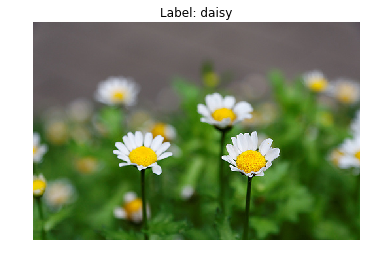

In [58]:
CamaraPhotos(dsets['train'], labels)

In [118]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [119]:
# Turn up tolerance for faster convergence
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
predictions = logisticRegr.predict(X_test)

In [121]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.892107892108


In [122]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
        index +=1

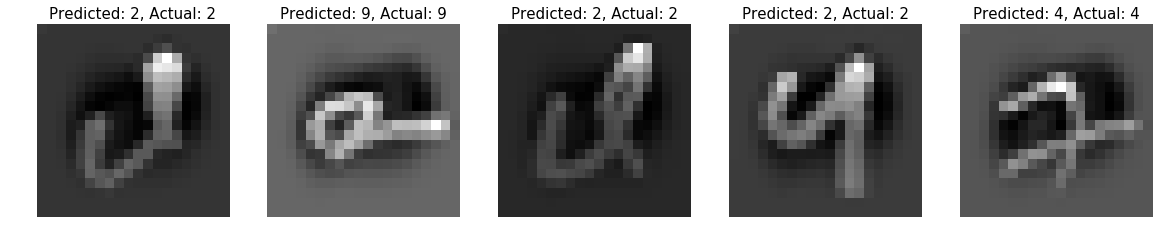

In [123]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (20,20)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)